In [2]:
import os
import sys

sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from tqdm import tqdm

from kwave.ktransducer import kWaveGrid
from models.das import DelayAndSum
from models.pact import SOS2Wavefront, Wavefront2TF
from utils.dataio import load_mat
from utils.reconstruction import get_coordinates, wavefront_real
from utils.simulations import get_water_sos
# from utils.utils_torch import crop_half, get_fourier_coord
from utils.visualization import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.rcParams.update({'font.weight': 'semibold', 'font.family': 'DejaVu Serif'})

data_path = '../data/'
RESULTS_DIR = '../results_ICCV/numerical_full_apact/'

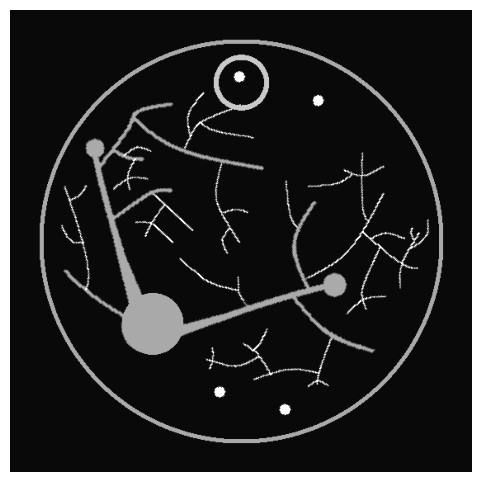

In [3]:
IP_gt = standardize(load_mat(os.path.join(data_path, 'IP_APACT_1.mat')))
fig, ax = plt.subplots(figsize=(6,6))
norm = Normalize(vmax=5, vmin=-0.5)
plt.imshow(IP_gt, cmap='gray', norm = norm)
plt.axis('off')
plt.savefig('IP_nf_apact.png', bbox_inches='tight', pad_inches=0, dpi=256)

### Sinogram

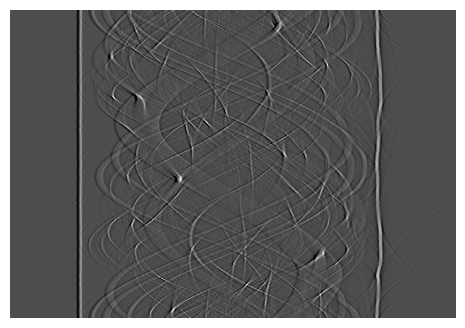

In [4]:
sinogram = load_mat(os.path.join(data_path, 'sinogram_full_apact.mat'))

plt.figure(figsize=(6,4))
plt.imshow(sinogram[:,960:1700], cmap='gray', norm=Normalize(vmin=-0.07, vmax=0.16))
plt.axis('off')
plt.savefig('sinogram.png', bbox_inches='tight', pad_inches=0, dpi=256)

### Preparations

Select a patch.

In [5]:
i, j = 18, 13
idx, idy = 20*i+40, 20*j+40
x, y, r, phi = get_coordinates(i, j, 3.2e-3)

In [6]:
Nx, Ny = 560, 560
dx, dy = 4e-5, 4e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
x_vec, y_vec = kgrid.x_vec, kgrid.y_vec

In [7]:
R = 9.8e-3              # Radius of single body [m].
T = 26.0                # Water temperature [C].
v0 = get_water_sos(T)   # Background SoS [m/s].
delays = np.linspace(-9.e-4, 8.e-4, 6)

### Full Image Stack

In [8]:
das = DelayAndSum(R_ring=0.05, N_transducer=512, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, mode='zero')
das.to(device)
das.eval()

DelayAndSum()

In [9]:
img_stack = []
with torch.no_grad():
    for d_delay in tqdm(delays, desc='DAS'):
        recon = das(sinogram=torch.tensor(sinogram).to(device), 
                    v0=torch.tensor(v0, device=device),
                    d_delay=torch.tensor(d_delay, device=device),
                    ring_error=torch.zeros(1, device=device))
        img_stack.append(recon)
img_stack = torch.stack(img_stack, dim=0).detach().cpu().numpy()

DAS: 100%|██████████| 6/6 [00:00<00:00,  9.83it/s]


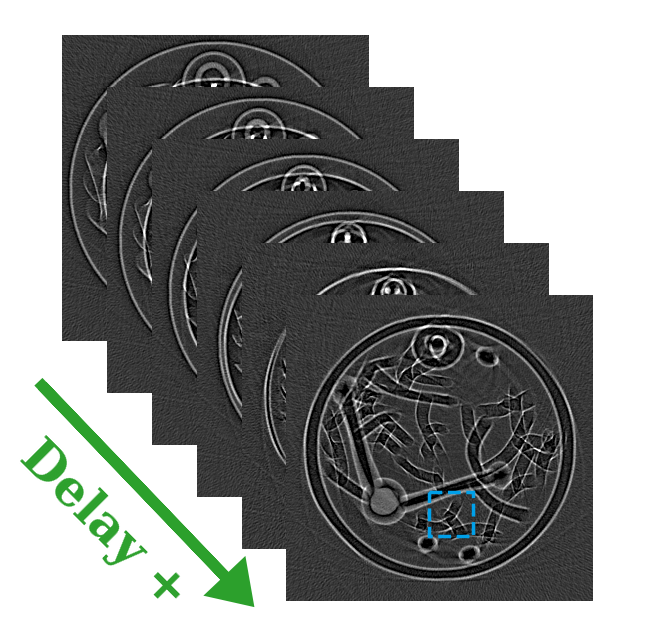

In [10]:
fig = plt.figure(figsize=(8,8), facecolor='white')
norm = Normalize(vmax=5, vmin=-1.5)
step = 40
gs = GridSpec(12, 14)
ax = plt.subplot(gs[0:12,0:14])
ax.set_zorder(10)
plt.axis('off')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.arrow(4, 39, 30, -31.5, color='tab:green', linewidth=8, head_width=6, head_length=4.5)
plt.text(s='Delay +', x=-1.2, y=3, color='tab:green', fontsize=36, fontweight='bold', rotation=-45)
for k in range(6):
    ax = plt.subplot(gs[k:k+7,k+1:k+8])
    plt.imshow(standardize(img_stack[k,:,:]), cmap='gray', norm=norm)
    plt.axis('off')
    rect = Rectangle((idy-40, idx-40), 80, 80, linewidth=2.5, linestyle='--', edgecolor='#00A0E9', facecolor='none')
    ax.add_patch(rect)
# plt.tight_layout()
plt.savefig('img_stack_marked.png', bbox_inches='tight', pad_inches=0, dpi=256)

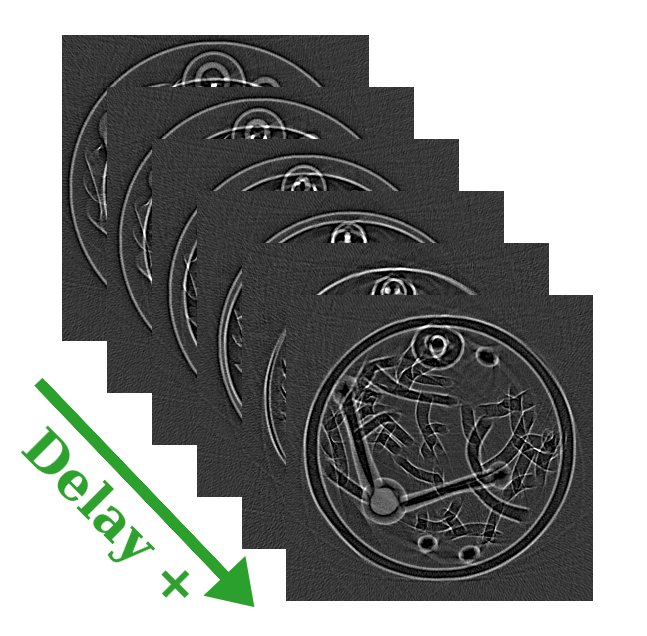

In [11]:
fig = plt.figure(figsize=(8,8), facecolor='white')
norm = Normalize(vmax=5, vmin=-1.5)
step = 40
gs = GridSpec(12, 14)
ax = plt.subplot(gs[0:12, 0:14])
ax.set_zorder(10)
plt.axis('off')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.arrow(4, 39, 30, -31.5, color='tab:green', linewidth=8, head_width=6, head_length=4.5)
plt.text(s='Delay +', x=-1.2, y=3, color='tab:green', fontsize=38, fontweight='bold', rotation=-45)
for k in range(6):
    ax = plt.subplot(gs[k:k+7,k+1:k+8])
    plt.imshow(standardize(img_stack[k,:,:]), cmap='gray', norm=norm)
    plt.axis('off')
plt.savefig('img_stack.png', bbox_inches='tight', pad_inches=0, dpi=256)

### Small Patch Image Stack

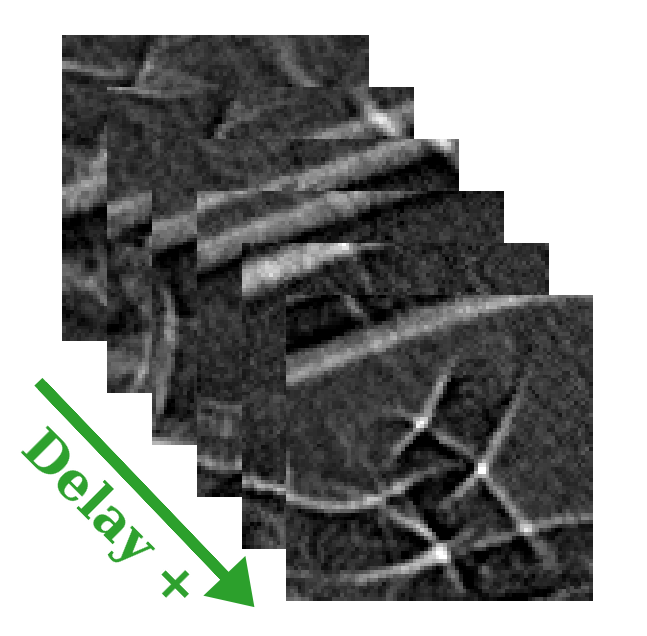

In [12]:
fig = plt.figure(figsize=(8,8), facecolor='white')
step = 40
gs = GridSpec(12, 14)
ax = plt.subplot(gs[0:12,0:14])
ax.set_zorder(10)
plt.axis('off')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.arrow(4, 39, 30, -31.5, color='tab:green', linewidth=8, head_width=6, head_length=4.5)
plt.text(s='Delay +', x=-1.2, y=3, color='tab:green', fontsize=38, fontweight='bold', rotation=-45)
for k in range(6):
    plt.subplot(gs[k:k+7,k+1:k+8])
    plt.imshow(standardize(img_stack[k,20*i:20*i+80, 20*j:20*j+80]), cmap='gray', norm=norm)
    plt.axis('off')
plt.savefig('img_stack_patch.png', bbox_inches='tight', pad_inches=0, dpi=256)

### Deblurred Full Image

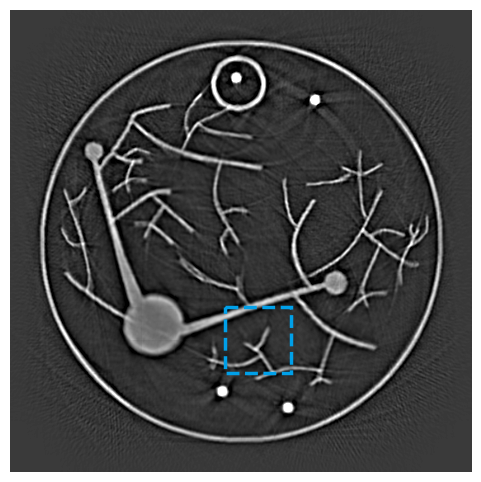

In [13]:
IP_nf_apact = load_mat(os.path.join(RESULTS_DIR, 'NF-APACT', '32delays_0lyrs_128fts_10epochs_bs=64_lr=5.0e-03', 'IP_rec.mat'))
IP_nf_apact = standardize(IP_nf_apact)

fig, ax = plt.subplots(figsize=(6,6))
plt.imshow(IP_nf_apact, cmap='gray', norm=norm)
plt.axis('off')
rect = Rectangle((idy-40, idx-40), 80, 80, linewidth=2.5, linestyle='--', edgecolor='#00A0E9', facecolor='none')
ax.add_patch(rect)
plt.savefig('IP_nf_apact_marked.png', bbox_inches='tight', pad_inches=0, dpi=256)

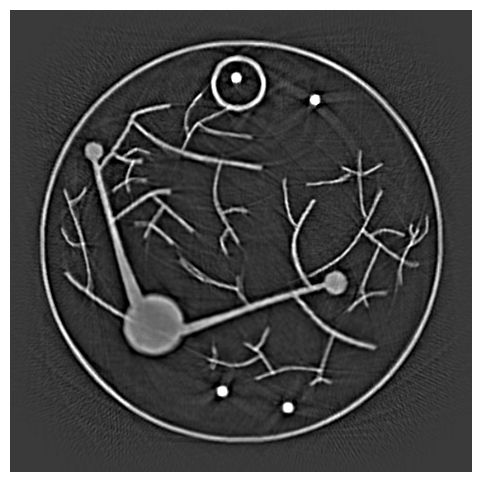

In [14]:
fig, ax = plt.subplots(figsize=(6,6))
plt.imshow(IP_nf_apact, cmap='gray', norm=norm)
plt.axis('off')
plt.savefig('IP_nf_apact.png', bbox_inches='tight', pad_inches=0, dpi=256)

### Clean Small Patch

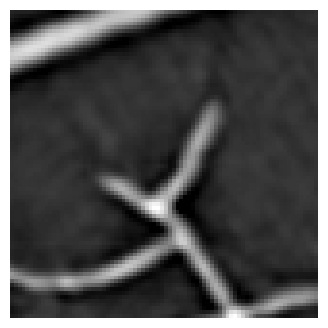

In [15]:
plt.figure(figsize=(4,4))
plt.imshow(IP_nf_apact[20*i:20*i+80, 20*j:20*j+80], cmap='gray', norm=norm)
plt.axis('off')
plt.savefig('IP_nf_apact_patch.png', bbox_inches='tight', pad_inches=0, dpi=256)

### SoS

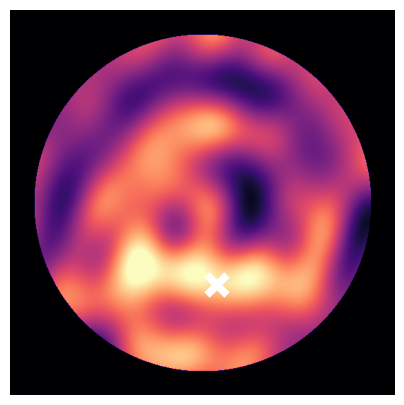

In [16]:
SOS_nf_apact = load_mat(os.path.join(RESULTS_DIR, 'NF-APACT', '32delays_0lyrs_128fts_10epochs_bs=64_lr=5.0e-03', 'SOS_rec.mat'))

plt.figure(figsize=(5,5))
norm_sos = Normalize(vmax=1600, vmin=1500)
# plt.title(loc='left', label='$V_b$', fontsize=27, y=0.85, x=0.1, color="white")
# plt.title(loc='right', label='$V_a$', fontsize=27, y=0.75, x=0.5, color="black")
plt.imshow(SOS_nf_apact, cmap='magma', norm=norm_sos)
plt.plot(idy, idx, marker='x', color='white', markersize=14, mew=5.5)
plt.axis('off')
plt.savefig('SOS_nf_apact_marked.png', bbox_inches='tight', pad_inches=0, dpi=256)

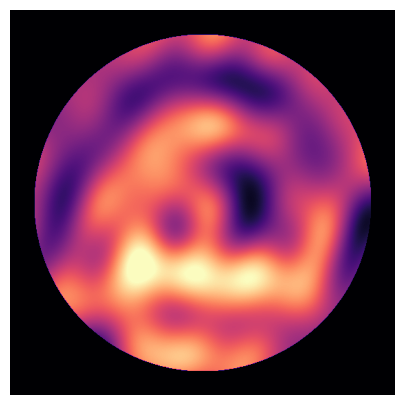

In [17]:
plt.figure(figsize=(5,5))
plt.imshow(SOS_nf_apact, cmap='magma', norm=norm_sos)
plt.axis('off')
plt.savefig('SOS_nf_apact.png', bbox_inches='tight', pad_inches=0, dpi=256)

### Wavefront & PSFT Stack

In [18]:
wavefront_sos = SOS2Wavefront(R, v0, x_vec, y_vec, n_thetas=180)
wavefront_sos.cuda()
wavefront_sos.eval()
tf_pact = Wavefront2TF(N=80, l=3.2e-3, n_delays=delays.shape[0])
tf_pact.cuda()
tf_pact.eval()

thetas, wfs = wavefront_sos(torch.tensor([x]).cuda(), torch.tensor([y]).cuda(), torch.tensor(SOS_nf_apact).cuda())
tfs = tf_pact(torch.tensor(delays).cuda().view(1,-1,1,1), thetas, wfs)
psfs = ifftshift(ifft2(tfs), dim=(-2,-1)).real

thetas = thetas.squeeze(0).detach().cpu().numpy()
wfs = wfs.squeeze(0).detach().cpu().numpy()
psfs = psfs.squeeze(0).detach().cpu().numpy()

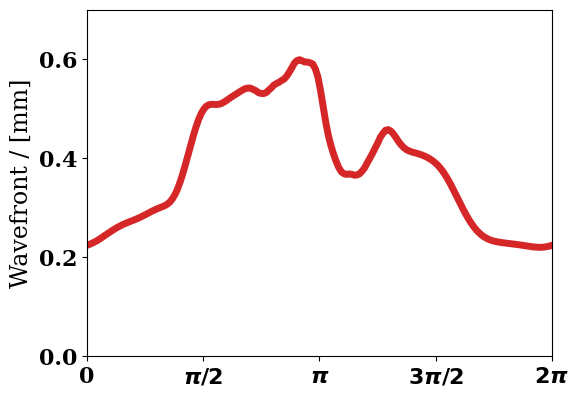

In [19]:
plt.figure(figsize=(6,4.5))
plt.plot(thetas, wfs*1e3, color='tab:red', label='Real', linewidth=5)
plt.xticks([0, np.pi/2, np.pi, 3*np.pi/2, 2*np.pi], ['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$'], fontsize=16)
plt.yticks([0, 0.2, 0.4, 0.6], ['0.0', '0.2', '0.4', '0.6'], fontsize=16)
plt.xlim([0, 2*np.pi])
plt.ylim([0.0, 0.7])
plt.ylabel('Wavefront / [mm]', fontsize=17)
# plt.xlabel('$\phi$', fontsize=16)
plt.savefig('wavefront.png', bbox_inches='tight', pad_inches=0.01, dpi=256)

### PSF Stack

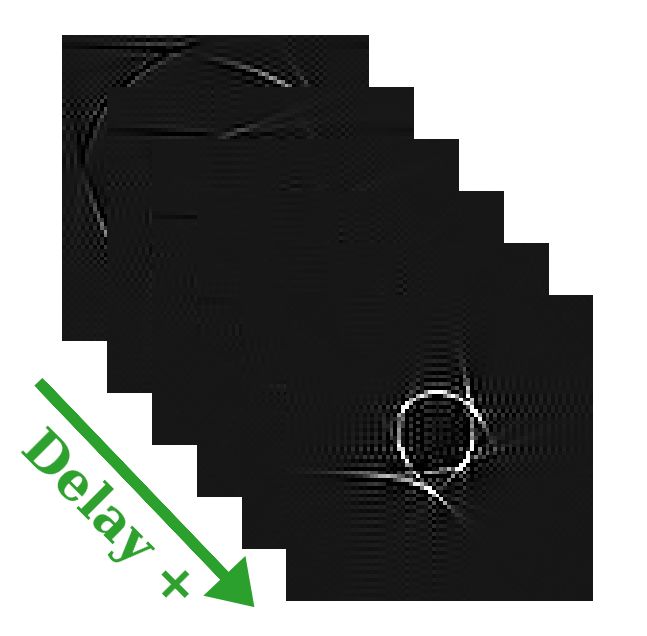

In [20]:
fig = plt.figure(figsize=(8,8), facecolor='white')
gs = GridSpec(12, 14)
ax = plt.subplot(gs[0:12,0:14])
# ax.set_zorder(10)
plt.axis('off')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.arrow(4, 39, 30, -31.5, color='tab:green', linewidth=8, head_width=6, head_length=4.5)
plt.text(s='Delay +', x=-1.2, y=3, color='tab:green', fontsize=38, fontweight='bold', rotation=-45)
for k in range(6):
    plt.subplot(gs[k:k+7,k+1:k+8])
    plt.imshow(psfs[k], cmap='gray', norm=Normalize(vmin=-0.005, vmax=0.05))
    plt.axis('off')
plt.savefig('psf_stack.png', bbox_inches='tight',pad_inches=0, dpi=256)

### Method Comparison

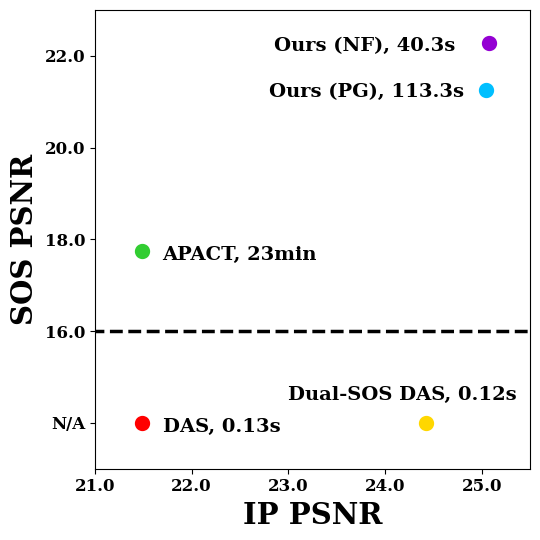

In [79]:
plt.figure(figsize=(5.5, 5.5))
plt.scatter([21.49], [14], color='red', label='o', linewidth=5)
plt.text(s='DAS, 0.13s', x=21.7, y=13.8, fontsize=14, color='black')

plt.scatter([24.42], [14], color='gold', label='o', linewidth=5)
plt.text(s='Dual-SOS DAS, 0.12s', x=23, y=14.5, fontsize=14, color='black')

plt.scatter([21.49], [17.74], color='limegreen', label='o', linewidth=5)
plt.text(s='APACT, 23min', x=21.7, y=17.55, fontsize=14, color='black')

plt.scatter([25.05], [21.26], color='deepskyblue', label='o', linewidth=5)
plt.text(s='Ours (PG), 113.3s', x=22.8, y=21.1, fontsize=14, color='black')

plt.scatter([25.08], [22.29], color='darkviolet', label='o', linewidth=5)
plt.text(s='Ours (NF), 40.3s', x=22.85, y=22.1, fontsize=14, color='black')
plt.hlines(16, 10, 30, color='black', linestyle='--', linewidth=2.5)

plt.ylabel('SOS PSNR', fontsize=21, fontweight='semibold')
plt.xlabel('IP PSNR', fontsize=21, fontweight='semibold')
plt.yticks([14, 16, 18, 20, 22], 
              ['N/A', '16.0', '18.0', '20.0', '22.0'],
              fontsize=12, fontweight='semibold')
plt.xticks([21, 22, 23, 24, 25], 
              ['21.0', '22.0', '23.0', '24.0', '25.0'],
              fontsize=12, fontweight='semibold')
plt.ylim([13,23])
plt.xlim([21,25.5])
plt.tight_layout()

plt.savefig('methods.png', bbox_inches='tight', dpi=256)